<a href="https://colab.research.google.com/github/Hassan-Mahadjir/Machine-Learning/blob/main/CNN_MINST_multiLayers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import torch.optim as optim
from torchvision import transforms, datasets

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Convert MNIST Files into Tensor of 4-D (# of images, Hight, Width, Colour channel)

transform = transforms.ToTensor()

In [ ]:
# Train Data
train_data = datasets.MNIST(root='./cnn_data', train=True, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.20MB/s]


In [ ]:
# test Data
test_data = datasets.MNIST(root='./cnn_data', train=False, download=True, transform=transform)

In [ ]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
# Create a small batch size for images
train_loader = Data.DataLoader(dataset=train_data, batch_size=10, shuffle=True)
test_loader = Data.DataLoader(dataset=test_data, batch_size=10, shuffle=False)

In [ ]:
# Define CNN Model
# Convolutional Neural Network (exercize)
# (input, output, filter_size(Kernal), stride)
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)


In [ ]:
# Grab 1 MNIST record/image
for i,(X_Train,Y_Train) in enumerate(train_data):
    break

In [ ]:
X_Train.shape

torch.Size([1, 28, 28])

In [ ]:
x = X_Train.view(1,1,28,28)

In [ ]:
# Perform our first convolution
x = F.relu(conv1(x))


In [ ]:
# 1 single image, 6 filter(s), 26x26
x.shape

torch.Size([1, 6, 26, 26])

In [ ]:
# Pass thru the pooling layer
x = F.max_pool2d(x, 2, 2) #kernal of 2 and stride of 2

In [ ]:
x.shape

torch.Size([1, 6, 13, 13])

In [ ]:
# Do our second convolutioal layer
x = F.relu(conv2(x))

In [ ]:
x.shape

torch.Size([1, 16, 11, 11])

In [ ]:
x = F.max_pool2d(x,2,2)

In [ ]:
x.shape

torch.Size([1, 16, 5, 5])

In [ ]:
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)
    # Fully Connected Layer
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2) # 2x2 kernal and stride 2
    # Second Pass
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2) # 2x2 kernal and stride 2

    # Re-View to flatten it out
    X = X.view(-1, 16*5*5) # negative one so that we can vary the batch size

    # Fully Connected Layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim=1)

The number for the fc1,fc2,fc3 are arbiriry, it it should endup with total number of classes we have in dataset ( 10) from 0 - 9

In [ ]:
# create an instance of our model

# Create an Instance of our Model
torch.manual_seed(41)
model = ConvolutionalNetwork()
model


ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
# Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # smaller teh learnign rate, longer it going to take to learn

In [ ]:
import time
start_time = time.time()

# Create Variables To Tracks Things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For Loop of Epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0


  # Train
  for b,(X_train, y_train) in enumerate(train_loader):
    b+=1 # start our batches at 1
    y_pred = model(X_train) # get predicted values from the training set. Not flattened 2D
    loss = criterion(y_pred, y_train) # how off are we? Compare the predictions to correct answers in y_train

    predicted = torch.max(y_pred.data, 1)[1] # add up the number of correct predictions. Indexed off the first point
    batch_corr = (predicted == y_train).sum() # how many we got correct from this batch. True = 1, False=0, sum those up
    trn_corr += batch_corr # keep track as we go along in training.

    # Update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # Print out some results
    if b%600 == 0:
      print(f'Epoch: {i}  Batch: {b}  Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)

  # Test
  with torch.no_grad(): #No gradient so we don't update our weights and biases with test data
    for b,(X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1] # Adding up correct predictions
      tst_corr += (predicted == y_test).sum() # T=1 F=0 and sum away


  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)



current_time = time.time()
total = current_time - start_time
print(f'Training Took: {total/60} minutes!')

Epoch: 0  Batch: 600  Loss: 0.012505742721259594
Epoch: 0  Batch: 1200  Loss: 0.059554439038038254
Epoch: 0  Batch: 1800  Loss: 0.01286345161497593
Epoch: 0  Batch: 2400  Loss: 0.13558034598827362
Epoch: 0  Batch: 3000  Loss: 0.004820442292839289
Epoch: 0  Batch: 3600  Loss: 0.010546308942139149
Epoch: 0  Batch: 4200  Loss: 0.24395230412483215
Epoch: 0  Batch: 4800  Loss: 0.007479517254978418
Epoch: 0  Batch: 5400  Loss: 0.009367642924189568
Epoch: 0  Batch: 6000  Loss: 0.0018434313824400306
Epoch: 1  Batch: 600  Loss: 0.03221464157104492
Epoch: 1  Batch: 1200  Loss: 0.003333463566377759
Epoch: 1  Batch: 1800  Loss: 0.04126342386007309
Epoch: 1  Batch: 2400  Loss: 0.14685525000095367
Epoch: 1  Batch: 3000  Loss: 0.12026345729827881
Epoch: 1  Batch: 3600  Loss: 0.0001952919119503349
Epoch: 1  Batch: 4200  Loss: 0.00016604487609583884
Epoch: 1  Batch: 4800  Loss: 0.0006250619189813733
Epoch: 1  Batch: 5400  Loss: 0.0019755663815885782
Epoch: 1  Batch: 6000  Loss: 0.0005515654920600355
Ep

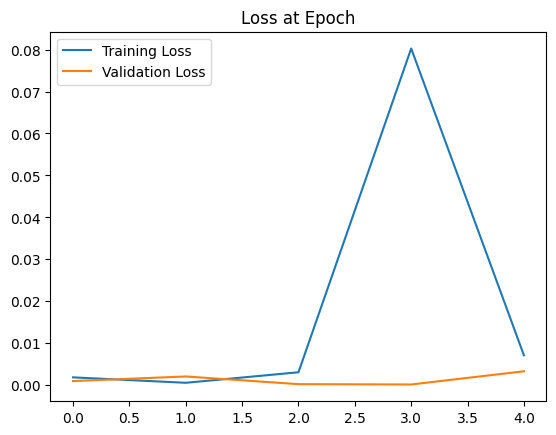

In [ ]:
# Graph the loss at epoch
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss at Epoch")
plt.legend()

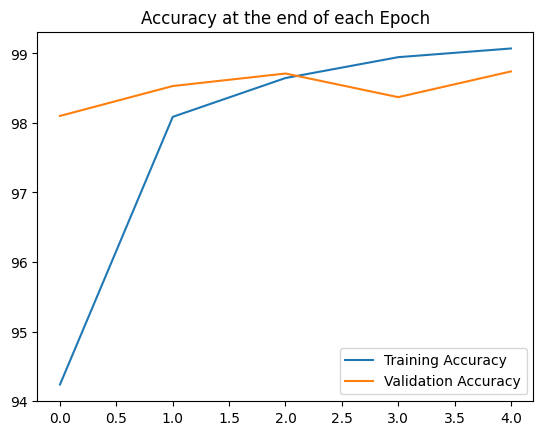

In [ ]:
# graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label="Training Accuracy")
plt.plot([t/100 for t in test_correct], label="Validation Accuracy")
plt.title("Accuracy at the end of each Epoch")
plt.legend()

In [ ]:
test_load_everthing = Data.DataLoader(dataset=test_data, batch_size=10000, shuffle=False)


In [ ]:
with torch.no_grad():
  correct = 0
  for b,(X_test, y_test) in enumerate(test_load_everthing):
    y_val = model(X_test)
    predicted = torch.max(y_val.data, 1)[1]
    correct += (predicted == y_test).sum()



In [ ]:
print(f'Test Accuracy: {(correct/10000)*100}')

Test Accuracy: 98.73999786376953
